In [1]:
import torch
import numpy as np
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as T
from torch.utils.data import DataLoader
from IPython.display import clear_output as co
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim import Adam
import seaborn as sns
sns.set_theme(style="darkgrid", font_scale = 0.7)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
mnist_transforms = T.Compose([
    T.Resize((64,64)),
    T.ToTensor(), 
    ])

device = 'cuda' if torch.cuda.is_available() else 'cpu'; print(f'Using {device}')
train_set = MNIST(root='./data', train=True, download=True, transform=mnist_transforms)
valid_set = MNIST(root='./data', train=False, download=True, transform=mnist_transforms)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=False)

def plot_stats(train_loss, valid_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(valid_loss, label='Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()


criterion = nn.MSELoss()

def train(model):
    optimizer = Adam(model.parameters(), lr = 1e-3)
    model.train()
    train_losses = 0
    for x, _ in tqdm(train_loader, desc = 'Train'):
        x = x.to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat, x)
        train_losses += loss.item()
        loss.backward()
        optimizer.step()
    return train_losses / len(train_loader)

@torch.inference_mode()
def valid(model):
    valid_losses = 0
    model.eval()
    for x, _ in tqdm(valid_loader, desc = 'Valid'):
        with torch.no_grad():
            x = x.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, x)
            valid_losses += loss.item()
    return valid_losses / len(valid_loader)


Using cuda


In [3]:
from torchvision.utils import make_grid

@torch.inference_mode()
def visual(model, xs):
    model.eval()
    z = model(xs.to(device)).cpu()
    plt.figure(figsize = (20, 4))

    img = T.ToPILImage()(torch.cat((
        make_grid(xs[:10], nrow = 10),
        make_grid(z[:10], nrow = 10)
    ), dim = 1))
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [4]:
def octava(model, epochs = 15):
    train_losses, valid_losses = [], []

    for e in range(epochs):
        train_loss = train(model)
        valid_loss = valid(model)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        co(wait = True)
        print(f"{e} / {epochs}")
        visual(model, next(iter(valid_loader))[0])
        plot_stats(train_losses, valid_losses)
        


In [5]:
class Block(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, upsample: bool = False):
        super().__init__()
        self.upsample = upsample

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=1,
            bias=False
        )
        self.norm = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        if self.upsample:
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False, recompute_scale_factor=False)

        return self.act(self.norm(self.conv(x)))


class AutoEncoder(nn.Module):
    def __init__(self, in_channels: int, base_block: nn.Module = Block, base_size: int = 32, num_blocks: int = 4):
        super().__init__()

        self.base_size = base_size

        # encoder creation

        encoder_blocks = []

        for i in range(num_blocks):
            encoder_blocks.append(
                base_block(
                    in_channels=base_size if i else in_channels,
                    out_channels=base_size,
                    kernel_size=3,
                    stride=2
                )
            )

        encoder_blocks.append(
            base_block(
                in_channels=base_size,
                out_channels=base_size,
                kernel_size=3
            ).conv
        )

        self.encoder = nn.Sequential(*encoder_blocks)  # N -> N // (2 ** num_blocks)

        # decoder creation

        decoder_blocks = []

        for i in range(num_blocks):
            decoder_blocks.append(
                base_block(
                    in_channels=base_size,
                    out_channels=base_size,
                    kernel_size=3,
                    upsample=True
                )
            )

        decoder_blocks.append(
            base_block(
                in_channels=base_size,
                out_channels=in_channels,
                kernel_size=3
            ).conv
        )
        decoder_blocks.append(nn.Sigmoid())

        self.decoder = nn.Sequential(*decoder_blocks)  # N // (2 ** num_blocks) -> N

        self.flatten = nn.Flatten()

    def forward(self, x):
        # x.shape = [bs, in_channels, N, N]
        x = self.encoder(x)
        # x.shape = [bs, base_size, N // (2 ** num_blocks), N // (2 ** num_blocks)]
        x = self.decoder(x)
        # x.shape = [bs, in_channels, N, N]

        return x

    @torch.inference_mode()
    def encode(self, x):
        # x.shape = [bs, in_channels, N, N]
        return self.flatten(self.encoder(x)) # output.shape = [bs, base_size * N ** 2 / (2 ** num_blocks) ** 2]

    @torch.inference_mode()
    def decode(self, x):
        # x.shape = [bs, base_size * N ** 2 / (2 ** num_blocks) ** 2]
        latent_size = int(np.sqrt(x.shape[1] // self.base_size))

        return self.decoder(x.view(-1, self.base_size, latent_size, latent_size))  # output.shape = [bs, in_channels, N, N]

In [ ]:
model = AutoEncoder(1).to(device)

if 'model.pth' in os.listdir():
    model.load_state_dict(torch.load('model.pth', weights_only = True))
else:
    octava(model)
    torch.save(model.state_dict(), 'model.pth')
    plt.savefig('learning_graph.png', bbox_inches='tight')

if 'learning_graph.png' in os.listdir():
    plt.imshow(plt.imread('learning_graph.png'))

In [23]:
@torch.inference_mode()
def get_interpolation(model, x1, x2):
    z1 = model.encode(x1.unsqueeze(0).to(device))
    z2 = model.encode(x2.unsqueeze(0).to(device))
    lin = torch.linspace(0, 1, 9).to(device).unsqueeze(1)

    concated = z1 * lin + z2 * (1 - lin)
    images = model.decode(concated)

    img = T.ToPILImage()(make_grid(images, nrow=9))
    plt.figure(figsize=(10, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

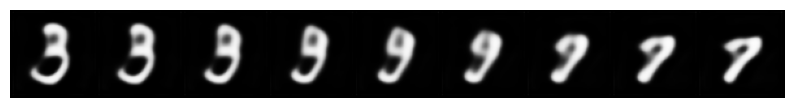

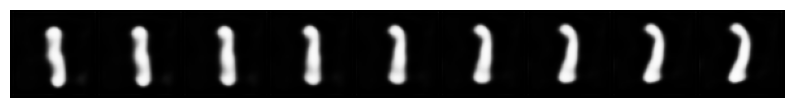

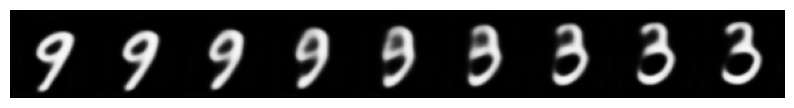

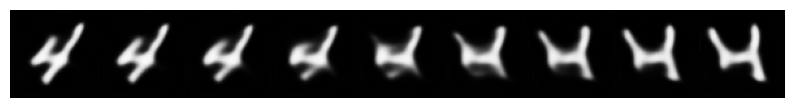

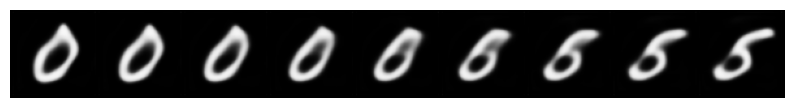

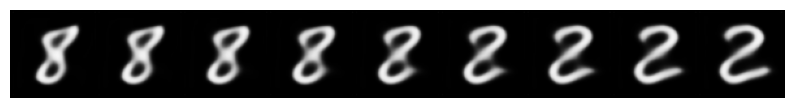

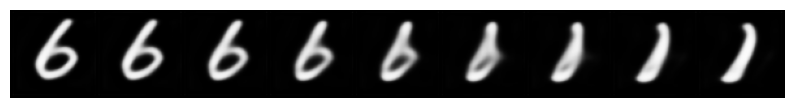

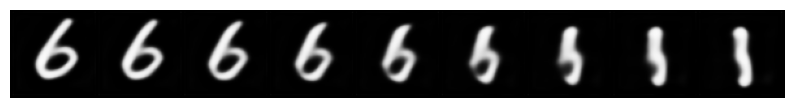

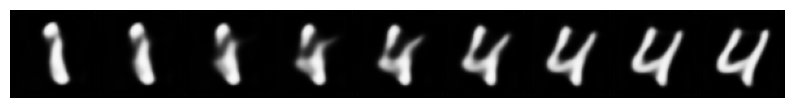

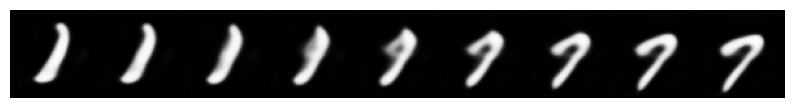

In [28]:
for i in range(10):
    x1, x2 = np.random.randint(len(valid_loader), size = 2)
    get_interpolation(model, train_set[x1][0], train_set[x2][0])

In [ ]:
class denBlock(Block):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, upsample: bool = False):
        super().__init__(in_channels, out_channels, kernel_size, stride, upsample)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):

        if self.upsample:
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False, recompute_scale_factor=False)
        if self.training:
            x = x + torch.rand_like(x) * 0.05
        
        return self.act(self.norm(self.conv(x)))
    
class denAutoEncoder(AutoEncoder):
    def __init__(self, in_channels: int, base_block: nn.Module = denBlock, base_size: int = 32, num_blocks: int = 4):
        super().__init__(in_channels, base_block, base_size, num_blocks)

    def forward(self, x):
        if self.training:
            x = torch.clip(x + torch.rand_like(x) * 0.1, min = 0, max = 1)
        
        x = self.encoder(x)
        x = self.decoder(x)
        return x

denoising_model = denAutoEncoder(1).to(device)

if 'denoising_model.pth' in os.listdir():
    denoising_model.load_state_dict(torch.load('denoising_model.pth', weights_only = True))
else:
    octava(denoising_model)
    plt.savefig('denoising_graph.png', bbox_inches='tight')
    torch.save(denoising_model.state_dict(), 'denoising_model.pth')

if 'denoising_graph.png' in os.listdir():
    plt.imshow(plt.imread('denoising_graph.png'))
